In [2]:
import numpy as np 
import urdf2casadi.urdfparser as u2c
from urdf2casadi.geometry import plucker
from urdf_parser_py.urdf import URDF, Pose
#import PyKDL as kdl
#import kdl_parser.kdl_parser_py.kdl_parser_py.urdf as kdlurdf
from timeit import Timer, timeit, repeat
import rbdl
import pybullet as pb


In [10]:
def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.0
        
def average(lst): 
    return sum(lst) / len(lst) 

#def C_kdl_func():
#    for j in range(njoints):
#        q_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        #qdot_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

#    kdl.ChainDynParam(kdlmodel, g_kdl).JntToCoriolis(q_kdl, qdot_kdl, C_kdl)

#timeit_kdl = repeat("M_kdl_func()", setup = "from __main__ import M_kdl_func", repeat = nrepeat, number = nitr)
#mintime_kdl[i] = min(timeit_kdl)
#mediantime_kdl[i] = median(timeit_kdl)
#averagetime_kdl[i] = average(timeit_kdl)

def C_u2c_func():   
    for j in range(njoints):
        q_none = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    C_u2c(q_none, qdot_none, qddot)
    
def C_pb_func():
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
    
    C_pb = pb.calculateInverseDynamics(pbmodel, q_none, qdot_none, qddot)
    
    
def C_rbdl_func():
    for j in range(njoints):
        q_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    rbdl.InverseDynamics(rbdlmodel, q_np, qdot_np, qddot_np, C_rbdl)



In [11]:
#pbmodel = pb.loadURDF("pantilt.urdf")
sim = pb.connect(pb.DIRECT)
#pbmodel = pb.loadURDF("/urdf4timing/1dof.urdf")
ndofs = 30
urdf_nr = list(range(ndofs + 1))
urdf_nr.pop(0)

#storage for timing data
mediantime_kdl = [None]*ndofs
mediantime_u2c = [None]*ndofs
mediantime_rbdl = [None]*ndofs
mediantime_pb = [None]*ndofs
mintime_kdl = [None]*ndofs
mintime_u2c = [None]*ndofs
mintime_rbdl = [None]*ndofs
mintime_pb = [None]*ndofs
averagetime_kdl = [None]*ndofs
averagetime_u2c = [None]*ndofs
averagetime_rbdl = [None]*ndofs
averagetime_pb = [None]*ndofs

nitr = 50000
nrepeat = 10
    
for i in range(ndofs):    
    print i
    #path_to_urdf = "/home/lillmaria/urdf2casadi/examples/timing/urdf4timing/" + str(urdf_nr[i]) + "dof.urdf"
    path_to_urdf = str(urdf_nr[i]) + "dof.urdf"
    end_link = "link" + str(urdf_nr[i])
    root = 'base_link'
    tip = end_link
    
    #ok, kdl_tree = kdlurdf.treeFromFile(path_to_urdf)
    #kdlmodel = kdl_tree.getChain(root,tip)
    
    rbdlmodel = rbdl.loadModel(path_to_urdf)
    pbmodel = pb.loadURDF(path_to_urdf, useFixedBase=True)
    asd = u2c.URDFparser()
    robot_desc = asd.from_file(path_to_urdf)
    
    jlist, names, qmax, qmin = asd.get_joint_info(root, tip)
    njoints = len(jlist)

    #g_kdl = kdl.Vector()
    #M_kdl = kdl.JntSpaceInertiaMatrix(njoints)
    
    #rbdl declarations
    q_np = np.zeros(njoints)
    qdot_np = np.zeros(njoints)
    qddot_np = np.zeros(njoints)
    C_rbdl = np.zeros(njoints)
    
    #kdl declatations
    #q_kdl = kdl.JntArray(njoints)
    #qdot_kdl = kdl.JntArray(njoints)
    
    #u2c and pybullet declarations
    q_none = [None]*njoints
    qdot_none = [None]*njoints
    C_pb = [None]*njoints
    
    qddot = []
    for i in range(njoints):
        qddot.append(0.)
    
    C_u2c = asd.get_inverse_dynamics_RNEA(root, tip)
    timeit_u2c = repeat("C_u2c_func()", setup = "from __main__ import C_u2c_func", repeat = nrepeat, number = nitr)
    mintime_u2c[i] = min(timeit_u2c)
    mediantime_u2c[i] = median(timeit_u2c)
    averagetime_u2c[i] = average(timeit_u2c)
    
    timeit_pb = repeat("C_pb_func()", setup = "from __main__ import C_pb_func", repeat = nrepeat, number = nitr)
    #print C_pb
    mintime_pb[i] = min(timeit_pb)
    mediantime_pb[i] = median(timeit_pb)
    averagetime_pb[i] = average(timeit_pb)
    
    timeit_rbdl = repeat("C_rbdl_func()", setup = "from __main__ import C_rbdl_func", repeat = nrepeat, number = nitr)
    mintime_rbdl[i] = min(timeit_rbdl)
    mediantime_rbdl[i] = median(timeit_rbdl)
    averagetime_rbdl[i] = average(timeit_rbdl)


    
    

0
1dof.urdf
1
2dof.urdf
2
3dof.urdf
3
4dof.urdf
4
5dof.urdf
5
6dof.urdf
6
7dof.urdf
7
8dof.urdf
8
9dof.urdf
9
10dof.urdf
10
11dof.urdf
11
12dof.urdf
12
13dof.urdf
13
14dof.urdf
14
15dof.urdf
15
16dof.urdf
16
17dof.urdf
17
18dof.urdf
18
19dof.urdf
19
20dof.urdf
20
21dof.urdf
21
22dof.urdf
22
23dof.urdf
23
24dof.urdf
24
25dof.urdf
25
26dof.urdf
26
27dof.urdf
27
28dof.urdf
28
29dof.urdf
29
30dof.urdf


In [12]:
print mintime_u2c

print mintime_pb

[0.9798460006713867, 1.1409409046173096, 1.2150249481201172, 1.2833740711212158, 1.3728139400482178, 1.4272840023040771, 1.5176379680633545, 1.5448169708251953, 1.646569013595581, 1.7046828269958496, 1.8000049591064453, 1.8329861164093018, 1.9341390132904053, 1.9516370296478271, 2.0391178131103516, 2.120511054992676, 2.2416770458221436, 2.2424957752227783, 2.415148973464966, 2.377779006958008, 2.5574989318847656, 2.4997267723083496, 2.680233955383301, 2.6081490516662598, 2.795736074447632, 2.7359580993652344, 2.91044282913208, 2.8446621894836426, 3.0417001247406006, 2.990041971206665]
[0.10997200012207031, 0.16757917404174805, 0.22202086448669434, 0.2738330364227295, 0.33002805709838867, 0.3847389221191406, 0.4417541027069092, 0.49291300773620605, 0.5489718914031982, 0.6042430400848389, 0.6559948921203613, 0.718142032623291, 0.776900053024292, 0.821303129196167, 0.8769590854644775, 0.9396131038665771, 0.9922988414764404, 1.0427989959716797, 1.1008970737457275, 1.1617729663848877, 1.215

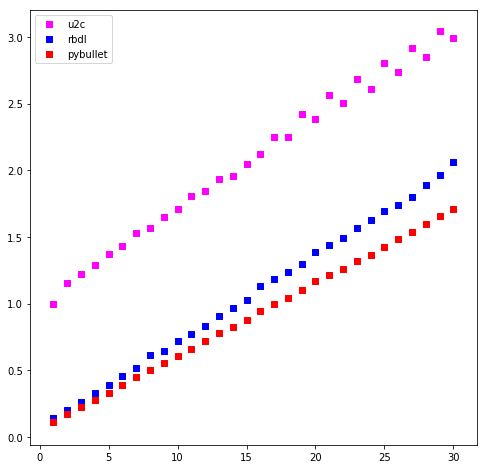

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

joint_nr = list(range(ndofs + 1))
joint_nr.pop(0)
med_fig = plt.figure(figsize = (8, 8))
#plt.scatter(joint_nr, mediantime_kdl, c='r', marker='x', label='kdl')
plt.scatter(joint_nr, mediantime_u2c, c='fuchsia', marker='s', label='u2c')
plt.scatter(joint_nr, mediantime_rbdl, c='b', marker='s', label='rbdl')
plt.scatter(joint_nr, mediantime_pb, c='r', marker='s', label='pybullet')
plt.legend(loc='upper left')
med_fig.show()

30
30


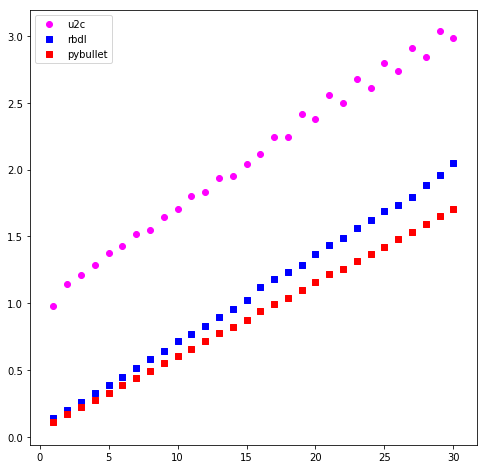

In [14]:
print len(joint_nr)
print len(mintime_u2c)

min_fig = plt.figure(figsize = (8, 8))
#plt.scatter(joint_nr, mintime_kdl, c='r', marker='x', label='kdl')
plt.scatter(joint_nr, mintime_u2c, c='fuchsia', label='u2c')
plt.scatter(joint_nr, mintime_rbdl, c='b', marker='s', label='rbdl')
plt.scatter(joint_nr, mintime_pb, c='r', marker='s', label='pybullet')
plt.legend(loc='upper left')
min_fig.show()